# Capstone Project Notebook

by Jianxu Shi   
Data Scientist in Training   
  
*This Jupyter notebook is built on IBM Skills Network Labs and will be mainly used for the Capstone project. 
The notebook is pushed to a Github repository and a link to the notebook will be shared.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import folium
!pip install lxml

     |████████████████████████████████| 5.8MB 24.9MB/s eta 0:00:01


In [2]:
# step 1: load incident data from King_County_Sheriff_s_Office.csv
file = 'King_County_Sheriff_s_Office.csv'
df = pd.read_csv(file)
df.head()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
0,907649447,C18044253,07/15/2018 08:00:32 PM,"112 - ASSAULT, SIMPLE","112 - ASSAULT, SIMPLE",NaN,30500 Block SE MUD MOUNTAIN RD,NaN,ENUMCLAW,WA,98022.0,NaN,47.150514,-121.947497,02/21/2019 12:31:47 AM,02/21/2019 12:32:52 AM,POINT (-121.9474973 47.1505137),20,Sunday,Assault
1,907652401,C18031527,07/16/2018 02:40:39 AM,350 - BOMBING,350 - BOMBING,NaN,17000 Block NE 160TH PL,NaN,WOODINVILLE,WA,98072.0,NaN,47.744960,-122.112058,02/21/2019 01:23:46 AM,02/21/2019 01:24:47 AM,POINT (-122.1120585 47.74496),2,Monday,Other
2,901799644,C18031534,07/16/2018 08:37:43 AM,150 - SEXUAL OFFENDER REGISTRATION VIOLATION,150 - SEXUAL OFFENDER REGISTRATION VIOLATION,NaN,1 Block S WASHINGTON ST,NaN,SEATTLE,WA,98104.0,NaN,47.600670,-122.335285,01/17/2019 06:55:19 PM,02/21/2019 12:17:40 AM,POINT (-122.3352848 47.6006697),8,Monday,Other Sexual Offense
3,907649790,C18031562,07/16/2018 10:40:00 AM,169 - CPS REFERRAL,169 - CPS REFERRAL,NaN,11400 Block 164TH AVE SE,NaN,RENTON,WA,98059.0,NaN,47.499569,-122.121825,02/21/2019 12:35:03 AM,02/21/2019 12:36:06 AM,POINT (-122.1218251 47.499569),10,Monday,Other
4,907652450,C18032953,07/16/2018 01:36:14 PM,"503 - CRIMINAL WARRANT, FELONY","503 - CRIMINAL WARRANT, FELONY",NaN,400 Block 4TH AVE N,NaN,KENT,WA,98032.0,NaN,47.384700,-122.238166,02/21/2019 01:23:59 AM,02/21/2019 01:25:00 AM,POINT (-122.2381664 47.3847003),13,Monday,Other


In [3]:
# step 2: process the data into a desired dataframe

# select only necessary features, drop rows with NA
features = ['incident_id','incident_datetime','address_1','zip','city','parent_incident_type']
df = df[features]
df.dropna(axis=0, inplace=True)

# change zip type to int, note valid range of zip codes in King county is 98001 - 98288
df.zip = df.zip.astype(int)
df = df[df.zip.between(98001,98288, inclusive=True)]
df.reset_index(drop=True)

# (AUBURN, 98022) is not valid (name: 5214, address: 40600 Block 218TH AVE SE), change to (ENUMCLAW, 98002)
#print(df.loc[(df['city']=='AUBURN') & (df['zip']==98022)])
df.loc[(df['city']=='AUBURN') & (df['zip']==98022), 'city'] = 'ENUMCLAW'
#print(df.loc[5214,:])

# (BARING, 98251) is not valid (7 instances), find another zip code 98224, change to (BARING, 98224)
#print(df.loc[(df['city']=='BARING') & (df['zip']==98251)])
df.loc[(df['city']=='BARING') & (df['zip']==98251), 'zip'] = 98224
#print(df.loc[(df['city']=='BARING') & (df['zip']==98251)])

# (CASCADE-FAIRWOOD, 98058) is not valid, USPS preferred city is Renton, change to (RENTON, 98058)
#print(df.loc[(df['city']=='CASCADE-FAIRWOOD') & (df['zip']==98058)])
df.loc[(df['city']=='CASCADE-FAIRWOOD') & (df['zip']==98058), 'city'] = 'RENTON'
#print(df.loc[(df['zip']==98058)])

# "KING COUNTY" was mistakenly entered as city (89 instances), drop to avoid confusion
df.drop(df[df.city == 'KING COUNTY'].index, inplace=True)
#print(df.loc[(df['city']=='KING COUNTY')])

# (DUVALL, 98155) is not valid (1 instance), find preferred city of 98155 (Seattle), change to (SEATTLE, 98155)
df.loc[(df['city']=='DUVALL') & (df['zip']==98155), 'city'] = 'SEATTLE'
#print(df.loc[(df['zip']==98155), 'city'].value_counts())

# (SEATTLE, 98155) is not valid (8 instances), drop to avoid confusion
df.drop(df[(df.city=='SEATTLE') & (df.zip==98155)].index, inplace=True)
#print(df.loc[(df['zip']==98155), 'city'].value_counts())

# (EAST RENTON HIGHLANDS, 98038) is not valid (6 instances), change to preferred city (MAPLE VALLEY, 98038)
df.loc[(df['city']=='EAST RENTON HIGHLANDS') & (df['zip']==98038), 'city'] = 'MAPLE VALLEY'
#print(df.loc[(df['zip']==98038), 'city'].value_counts())

# (ENCUMCLAW, 98092) is not valid (1 instance), change to preferred city (AUBURN, 98092)
df.loc[(df['city']=='ENCUMCLAW') & (df['zip']==98092), 'city'] = 'AUBURN'
#print(df.loc[(df['zip']==98092), 'city'].value_counts())

# (HOBART, 98059) is not valid (1 instance), change to preferred city (RENTON, 98059)
df.loc[(df['city']=='HOBART') & (df['zip']==98059), 'city'] = 'RENTON'
#print(df.loc[(df['zip']==98059), 'city'].value_counts())

# (KENT, 98065) is not valid (1 instance), change to preferred city (SNOQUALMIE, 98065)
df.loc[(df['city']=='KENT') & (df['zip']==98065), 'city'] = 'SNOQUALMIE'
#print(df.loc[(df['zip']==98065), 'city'].value_counts())

# (LEAVENWORTH, 98288) is not valid (1 instance), change to preferred city (SKYKOMISH, 98288)
df.loc[(df['city']=='LEAVENWORTH') & (df['zip']==98288), 'city'] = 'SKYKOMISH'
# SKYCOMISH is a typo for SKYKOMISH (1 instance), correct the city name
df.loc[(df['city']=='SKYCOMISH'), 'city'] = 'SKYKOMISH'
#print(df.loc[(df['zip']==98288), 'city'].value_counts())

# (LYNNWOOD, 98003) is not valid (1 instance), change to preferred city (FEDERAL WAY, 98003)
df.loc[(df['city']=='LYNNWOOD') & (df['zip']==98003), 'city'] = 'FEDERAL WAY'
#print(df.loc[(df['zip']==98003), 'city'].value_counts())

# (MAPLE VALLEY, 98031) is not valid (1 instance), change to preferred city (KENT, 98031)
df.loc[(df['city']=='MAPLE VALLEY') & (df['zip']==98031), 'city'] = 'KENT'
#print(df.loc[(df['zip']==98031), 'city'].value_counts())

# (UNINCORPORATED, 98027) is not valid (1 instance), change to preferred city (ISSAQUAH, 98027)
df.loc[(df['city']=='UNINCORPORATED') & (df['zip']==98027), 'city'] = 'ISSAQUAH'
#print(df.loc[(df['zip']==98027), 'city'].value_counts())

# (UNINCORPORATED KING COUNTY, 98051) is not valid (1 instance), change to preferred city (RAVENSDALE, 98051)
df.loc[(df['city']=='UNINCORPORATED KING COUNTY') & (df['zip']==98051), 'city'] = 'RAVENSDALE'
#print(df.loc[(df['zip']==98051), 'city'].value_counts())

# (UNION HILL-NOVELTY HILL, 98077) is not valid (1 instance), change to preferred city (WOODINVILLE, 98051)
df.loc[(df['city']=='UNION HILL-NOVELTY HILL') & (df['zip']==98077), 'city'] = 'WOODINVILLE'
#print(df.loc[(df['zip']==98077), 'city'].value_counts())

# group by (city, zip), count the total number of incidents
df_cz = df.groupby(['city','zip']).count()

# reset index, column name
df_cz.reset_index(inplace=True)
df_cz = df_cz[['city','zip','incident_id']]
df_cz.columns = ['City','Zip','Incident_count']

print("There are {} (city, zip) reporting total {} incidents".format(df_cz.shape[0], df_cz.Incident_count.sum()))
df_cz.head()

There are 208 (city, zip) reporting total 16419 incidents


,City,Zip,Incident_count
0,ALGONA,98001,7
1,AUBURN,98001,962
2,AUBURN,98002,161
3,AUBURN,98003,3
4,AUBURN,98030,3


In [4]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         237 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

In [5]:
import json # library to handle JSON files
address = 'SEATTLE, WA'

geolocator = Nominatim(user_agent="Seattle")
location = geolocator.geocode(address)
latitude_se = location.latitude
longitude_se = location.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude_se, longitude_se))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


In [240]:
# initialize two new columns ['Latitude', 'Longitude']
df_cz['Latitude'] = np.zeros(len(df_cz.index))
df_cz['Longitude'] = np.zeros(len(df_cz.index))

# extract coordinates for each (city, zip) pair and fill in the two new columns
for index, row in df_cz.iterrows():
    address = '{}, {}'.format(row['City'], row['Zip'])
    print(address)
    geolocator = Nominatim(user_agent="Washington")
# persistently getting geographical coordinates
    location = None
    while (location is None):
        location = geolocator.geocode(address)
    
    df_cz.loc[index, 'Latitude'] = location.latitude
    df_cz.loc[index, 'Longitude'] = location.longitude
    print(df_cz.loc[index, 'Latitude'], df_cz.loc[index,'Longitude'])

df_cz.head()

ALGONA, 98001
47.2784027 -122.2542238
AUBURN, 98001
47.3075369 -122.2301808
AUBURN, 98002
47.3075369 -122.2301808
AUBURN, 98003
47.3075369 -122.2301808
AUBURN, 98030
47.3075369 -122.2301808
AUBURN, 98042
47.28796825 -122.179321158385
AUBURN, 98092
47.3075369 -122.2301808
BARING, 98224
47.7731614 -121.485382
BEAUX ARTS VILLAGE, 98004
47.5854704 -122.199768
BELLEVUE, 98004
47.6144219 -122.1923372
BELLEVUE, 98005
47.6144219 -122.1923372
BELLEVUE, 98006
47.6144219 -122.1923372
BELLEVUE, 98007
47.6144219 -122.1923372
BELLEVUE, 98008
47.6144219 -122.1923372
BELLINGHAM, 98229
48.7544012 -122.4788361
BLACK DIAMOND, 98010
47.3083078 -122.0037583
BLACK DIAMOND, 98022
47.3083078 -122.0037583
BLACK DIAMOND, 98092
32.0835553 34.8043152
BOTHELL, 98011
47.7598697 -122.2068288
BOTHELL, 98012
47.7598697 -122.2068288
BOW, 98232
48.5617742 -122.3982194
BRIER, 98036
47.7845419 -122.2742948
BRYN MAWR-SKYWAY, 98178
47.494425 -122.243546159168
BURIEN, 98108
47.469918 -122.3485274
BURIEN, 98146
47.469918 -122

,City,Zip,Incident_count,Latitude,Longitude
0,ALGONA,98001,7,47.278403,-122.254224
1,AUBURN,98001,962,47.307537,-122.230181
2,AUBURN,98002,161,47.307537,-122.230181
3,AUBURN,98003,3,47.307537,-122.230181
4,AUBURN,98030,3,47.307537,-122.230181


In [248]:
# limit the area to latitude between (47, 49) and longitude between (-123, -121)
print(df_cz.shape)
df_clean = df_cz[(df_cz.Latitude.between(47, 49) & df_cz.Longitude.between(-123, -121))]
print(df_clean.shape)

(208, 5)
(204, 5)


In [249]:
# save (City, Zip, Incident_count, Latitude, Longitude) back to csv for future use
file = 'King_County_City_Zip_Incident_count_Lat_Lon.csv'
df_clean.to_csv(file, index=False)

In [6]:
# load (City, Zip, Incident_count, Latitude, Longitude) previously saved
file = 'King_County_City_Zip_Incident_count_Lat_Lon.csv'
df_clean = pd.read_csv(file)
df_clean.head()

,City,Zip,Incident_count,Latitude,Longitude
0,ALGONA,98001,7,47.278403,-122.254224
1,AUBURN,98001,962,47.307537,-122.230181
2,AUBURN,98002,161,47.307537,-122.230181
3,AUBURN,98003,3,47.307537,-122.230181
4,AUBURN,98030,3,47.307537,-122.230181


In [7]:
# inspect dataframe
df_clean.Zip = df_clean.Zip.astype(str)
df_clean.describe(include='all')

,City,Zip,Incident_count,Latitude,Longitude
count,204,204,204.000000,204.000000,204.000000
unique,74,103,NaN,NaN,NaN
top,SEATTLE,98001,NaN,NaN,NaN
freq,39,8,NaN,NaN,NaN
mean,NaN,NaN,80.450980,47.563982,-122.180641
std,NaN,NaN,202.581717,0.230108,0.191447
min,NaN,NaN,1.000000,47.204779,-122.905462
25%,NaN,NaN,2.000000,47.419256,-122.330062
50%,NaN,NaN,7.000000,47.520847,-122.227027
75%,NaN,NaN,54.000000,47.614422,-122.078813


In [8]:
# multiple (city, zip) combinations may return the same coordinates, group by (lat, long)
grouped = df_clean.groupby(['Latitude', 'Longitude'], as_index=False, sort=False).agg({
    'City':'first', 'Zip':', '.join, 'Incident_count':'sum'})

grouped.head()

,Latitude,Longitude,City,Zip,Incident_count
0,47.278403,-122.254224,ALGONA,98001,7
1,47.307537,-122.230181,AUBURN,"98001, 98002, 98003, 98030, 98092",1534
2,47.287968,-122.179321,AUBURN,98042,1
3,47.773161,-121.485382,BARING,98224,18
4,47.585470,-122.199768,BEAUX ARTS VILLAGE,98004,1


In [9]:
file = 'grouped.csv'
grouped.to_csv(file, index=False)

In [10]:
grouped.City = grouped.City + '_' + grouped.Zip.str[:5]


grouped.head()

,Latitude,Longitude,City,Zip,Incident_count
0,47.278403,-122.254224,ALGONA_98001,98001,7
1,47.307537,-122.230181,AUBURN_98001,"98001, 98002, 98003, 98030, 98092",1534
2,47.287968,-122.179321,AUBURN_98042,98042,1
3,47.773161,-121.485382,BARING_98224,98224,18
4,47.585470,-122.199768,BEAUX ARTS VILLAGE_98004,98004,1


In [11]:
# set color scheme for location label
max_incident = grouped.Incident_count.max()
x = np.arange(max_incident)
ys = [i + x + (i*x)**2 for i in range(max_incident)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [12]:
# create map of Seattle using latitude and longitude values
map_incidents = folium.Map(location=[latitude_se, longitude_se], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, city, inci in zip(grouped['Latitude'], grouped['Longitude'], 
                                     grouped['City'], grouped['Incident_count']):
    label = folium.Popup(str(city) + ' [' + str(inci) + ']', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color=rainbow[inci-1],
        fill=True,
        fill_color=rainbow[inci-1],
        fill_opacity=0.75).add_to(map_incidents)

map_incidents

In [13]:
# @hidden_cell
CLIENT_ID = 'D4HWMP1ULFHF5WXNORH44OCY4Y52HDARDHYDZLSHE4YF0IVB' # your Foursquare ID
CLIENT_SECRET = 'N4SEJSBFQBEABJFBBTUI5PAM2NRT24E2TFM3HAUEBJE10VI5' # your Foursquare Secret
VERSION = '20190919' # Foursquare API version

In [14]:
# define a function that get nearby venues for each neighborhood, one by one
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# get nearby venues for each neighborhood in King county
LIMIT = 100
King_venues = getNearbyVenues(names=grouped['City'], latitudes=grouped['Latitude'], longitudes=grouped['Longitude'])

King_venues

ALGONA_98001
AUBURN_98001
AUBURN_98042
BARING_98224
BEAUX ARTS VILLAGE_98004
BELLEVUE_98004
BELLINGHAM_98229
BLACK DIAMOND_98010
BOTHELL_98011
BOW_98232
BRIER_98036
BRYN MAWR-SKYWAY_98178
BURIEN_98108
BURLINGTON_98233
CARNATION_98014
CARNATION_98053
COTTAGE LAKE_98052
COTTAGE LAKE_98077
COVINGTON_98042
COVINGTON_98092
DES MOINES_98032
DUVALL_98014
DUVALL_98019
EAST HILL-MERIDIAN_98031
EAST RENTON HIGHLANDS_98027
EASTSOUND_98245
EDMONDS_98026
ENUMCLAW_98022
ENUMCLAW_98092
EVERETT_98201
FALL CITY_98014
FEDERAL WAY_98001
FREELAND_98249
GOLD BAR_98251
HOBART_98027
ISSAQUAH_98027
ISSAQUAH_98059
ISSAQUAH_98065
KENMORE_98028
KENT_98001
KENT_98003
KENT_98038
KENT_98042
KENT_98058
KIRKLAND_98033
LAKE FOREST PARK_98155
LAKE MORTON-BERRYDALE_98042
LAKE STEVENS_98258
LAKELAND NORTH_98001
LAKELAND SOUTH_98001
LYNNWOOD_98036
MAPLE HEIGHTS-LAKE DESIRE_98058
MAPLE VALLEY_98038
MAPLE VALLEY_98051
MARYSVILLE_98270
MERCER ISLAND_98040
MIRRORMONT_98027
MONROE_98272
MOUNT VERNON_98273
MOUNTLAKE TERRACE_980

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALGONA_98001,47.278403,-122.254224,Tacos El Tajin,47.278953,-122.249825,Food
1,ALGONA_98001,47.278403,-122.254224,The Royal Bear Pub & Eatery,47.280199,-122.259564,Rock Club
2,ALGONA_98001,47.278403,-122.254224,Coco Joe's Tiki Bar & Grill,47.279415,-122.250873,Bar
3,ALGONA_98001,47.278403,-122.254224,Valley Mart,47.278966,-122.250159,Convenience Store
4,AUBURN_98001,47.307537,-122.230181,Sun Break Cafe,47.306689,-122.230740,Café
...,...,...,...,...,...,...,...
1266,WOODINVILLE_98011,47.754583,-122.158890,The Gift Horse Saddlery,47.755606,-122.161301,Gift Shop
1267,WOODINVILLE_98011,47.754583,-122.158890,Shell,47.754695,-122.164718,Gas Station
1268,WOODINVILLE_98011,47.754583,-122.158890,OshKosh B'gosh,47.757286,-122.156702,Kids Store
1269,WOODINVILLE_98011,47.754583,-122.158890,Minuteman Press,47.757882,-122.159414,Print Shop


In [16]:
King_venues.groupby('Neighborhood', sort=False).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ALGONA_98001,4,4,4,4,4,4
AUBURN_98001,29,29,29,29,29,29
AUBURN_98042,5,5,5,5,5,5
BARING_98224,3,3,3,3,3,3
BEAUX ARTS VILLAGE_98004,2,2,2,2,2,2
...,...,...,...,...,...,...
UNION HILL-NOVELTY HILL_98052,2,2,2,2,2,2
VASHON_98070,36,36,36,36,36,36
WHITE CENTER_98106,47,47,47,47,47,47


In [17]:
King_venues.describe(include='all')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,1271,1271.000000,1271.000000,1271,1271.000000,1271.000000,1271
unique,90,NaN,NaN,1107,NaN,NaN,247
top,SEATTLE_98101,NaN,NaN,Starbucks,NaN,NaN,Coffee Shop
freq,100,NaN,NaN,23,NaN,NaN,82
mean,NaN,47.662462,-122.187110,NaN,47.662140,-122.187548,NaN
std,NaN,0.329845,0.230103,NaN,0.329762,0.230338,NaN
min,NaN,47.204779,-122.905462,NaN,47.200485,-122.909485,NaN
25%,NaN,47.464979,-122.330062,NaN,47.464855,-122.332812,NaN
50%,NaN,47.603832,-122.203450,NaN,47.603783,-122.206185,NaN
75%,NaN,47.754583,-122.097523,NaN,47.754784,-122.096754,NaN


In [18]:
# one hot encoding
King_onehot = pd.get_dummies(King_venues[['Venue Category']], prefix="", prefix_sep="")

# add city (neighborhood) column back to dataframe
King_onehot['City'] = King_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [King_onehot.columns[-1]] + list(King_onehot.columns[:-1])
King_onehot = King_onehot[fixed_columns]

King_grouped = King_onehot.groupby('City', sort=False).sum().reset_index()
King_grouped

,City,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ALGONA_98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUBURN_98001,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,AUBURN_98042,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BARING_98224,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BEAUX ARTS VILLAGE_98004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,UNION HILL-NOVELTY HILL_98052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,VASHON_98070,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
87,WHITE CENTER_98106,1,0,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
88,WHITE CENTER_98146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# add Incident_count column
df_combined = King_grouped.merge(grouped, on='City', how='left') 
df_combined.drop(['Latitude','Longitude','Zip'], axis=1, inplace=True)

df_combined

,City,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Incident_count
0,ALGONA_98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,AUBURN_98001,0,0,1,0,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1534
2,AUBURN_98042,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,BARING_98224,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,18
4,BEAUX ARTS VILLAGE_98004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,UNION HILL-NOVELTY HILL_98052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
86,VASHON_98070,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,454
87,WHITE CENTER_98106,1,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,67
88,WHITE CENTER_98146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,133


In [20]:
# inspect the result and display the places with "lowest count of incidents"
#df_combined.describe()

df_low = df_combined.loc[df_combined.Incident_count<2]
df_high = df_combined.loc[df_combined.Incident_count > 500]

print("These places have the lowest count of incidents:\n")

df_low

These places have the lowest count of incidents:



,City,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Incident_count
2,AUBURN_98042,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,BEAUX ARTS VILLAGE_98004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,BELLINGHAM_98229,0,0,0,0,2,0,0,1,0,...,0,0,0,0,2,0,0,0,0,1
9,BOW_98232,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,BURLINGTON_98233,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
18,COVINGTON_98092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28,FREELAND_98249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32,ISSAQUAH_98059,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35,KENT_98003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42,LAKE STEVENS_98258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
# displace the places with the "highest count of incidents"
print("These places have some of the highest counts of incidents:\n")

df_high

These places have some of the highest counts of incidents:



,City,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Incident_count
1,AUBURN_98001,0,0,1,0,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1534
34,KENT_98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,503
64,RENTON_98001,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,1790
71,SEATTLE_98101,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,4981
74,SEATTLE_98146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1298


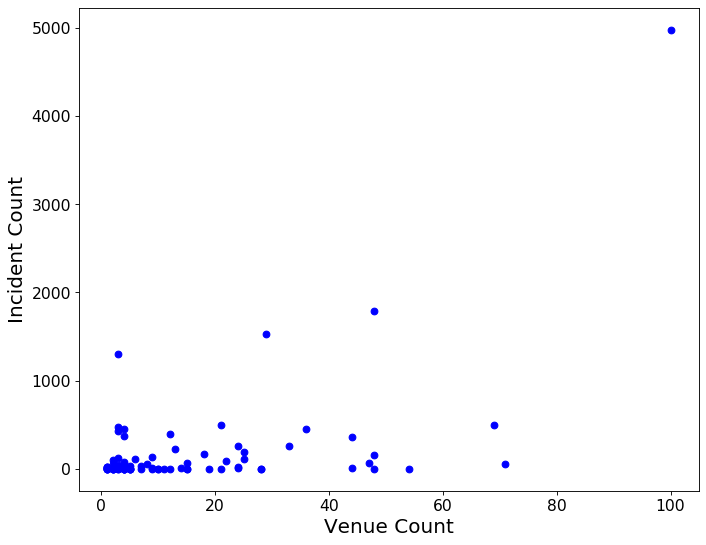

In [32]:
# let's visualize how incident count is related to venue count of places
X = df_combined.drop(['City', 'Incident_count'], axis=1)
x = pd.DataFrame(X.sum(axis=1))
y = df_combined['Incident_count']

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

plt.figure(figsize=(10,8), dpi=80)
plt.scatter(x, y, color='blue')
plt.xlabel("Venue Count", fontsize=18)
plt.ylabel("Incident Count", fontsize=18)
# plt.show()
plt.savefig('scatter_incident_venue_count.png')

Coefficients:  [  0.         -20.08539506   0.56706025]
Intercept:  157.43877250081783


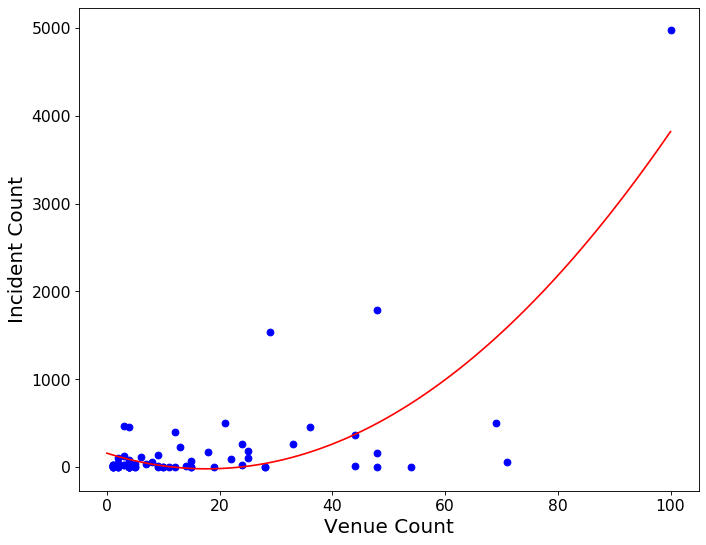

In [34]:
# the relationship looks non-linear so we will try polynomial
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
lr = linear_model.LinearRegression()
y_train_hat=lr.fit(x_train_pr, y_train)
print ('Coefficients: ', lr.coef_)
print ('Intercept: ',lr.intercept_)

#lr.score(x_test_pr, y_test)

plt.figure(figsize=(10,8), dpi=80)
plt.scatter(x_train, y_train,  color='blue')
XX = np.arange(0.0, 101.0, 1.0)
yy = lr.intercept_+ lr.coef_[1]*XX+ lr.coef_[2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("Venue Count", fontsize=18)
plt.ylabel("Incident Count", fontsize=18)
plt.savefig('polynomial_venue_count')

In [44]:
# now let's cpnsider multiple variables linear regression
from sklearn.metrics import r2_score
lm = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)
lm.fit(X_train, y_train)
yhat_test = lm.predict(X_test)

#print ('Coefficients: ', lm.coef_)
print('R2 score: %.2f' % r2_score(y_test, yhat_test))

R2 score: 0.22
